In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import the local utils.py file
import sys
sys.path.append(os.path.join(os.getcwd(), '../'))
from utils import load_config
from preprocessing.preprocessing_utils import build_df
from analysis_utils import searchc

In [2]:
config = load_config()
df = build_df()

In [3]:
# Find a model that describes the CPU Temperature as a function of the Liquid Temperature and the CPU Power Draw

In [11]:
cpu_temperature = np.array(df['CPU Package [°C]'])
liquid_temperature = np.array(df['Liquid Temperature [°C]'])
cpu_power = np.array(df['CPU Package Power [W]'])

liquid_temperature_valid_mask = liquid_temperature > 1

cpu_temperature = cpu_temperature[liquid_temperature_valid_mask]
liquid_temperature = liquid_temperature[liquid_temperature_valid_mask]
cpu_power = cpu_power[liquid_temperature_valid_mask]

In [12]:
# Use a random forest regressor to reduce the dataset size
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1)
rf.fit(np.array([liquid_temperature, cpu_power]).T, cpu_temperature);

In [13]:
# Fit a support vector regression to a dataset of the predicted random forest model
# Define an input dataset containing the predicted random forest model at each point of a grid
# The resolution has to be small enough for the SVM to converge in a reasonable amount of time
res = 150
x = np.linspace(liquid_temperature.min(), liquid_temperature.max(), res)
y = np.linspace(cpu_power.min(), cpu_power.max(), res)
X, Y = np.meshgrid(x, y)

Z_random_forest = rf.predict(np.array([X.ravel(), Y.ravel()]).T)

In [14]:
from sklearn.svm import SVR

svr = SVR(kernel='rbf', gamma=0.1)

# Fit the SVR to the prediction of the random forest model
svr.fit(np.array([X.ravel(), Y.ravel()]).T, Z_random_forest.ravel())

print(f'R² Score: {svr.score(np.array([X.ravel(), Y.ravel()]).T, Z_random_forest.ravel()):.2f}')

R² Score: 0.94


In [15]:
# Predict the CPU Temperature at each point of the grid
Z = svr.predict(np.array([X.ravel(), Y.ravel()]).T)
Z = Z.reshape(X.shape)

In [16]:
# Scale the input data to the image ranging from the minimum to the maximum of the input data in res points
liquid_temperature_scaled = (liquid_temperature - liquid_temperature.min()) / (liquid_temperature.max() - liquid_temperature.min()) * res
cpu_power_scaled = (cpu_power - cpu_power.min()) / (cpu_power.max() - cpu_power.min()) * res 

# Sample N points from the scaled input data
N = 2**9
sample_indices = np.random.choice(np.arange(len(liquid_temperature_scaled)), N, replace=False)
liquid_temperature_scaled_sample = liquid_temperature_scaled[sample_indices]
cpu_power_scaled_sample = cpu_power_scaled[sample_indices]

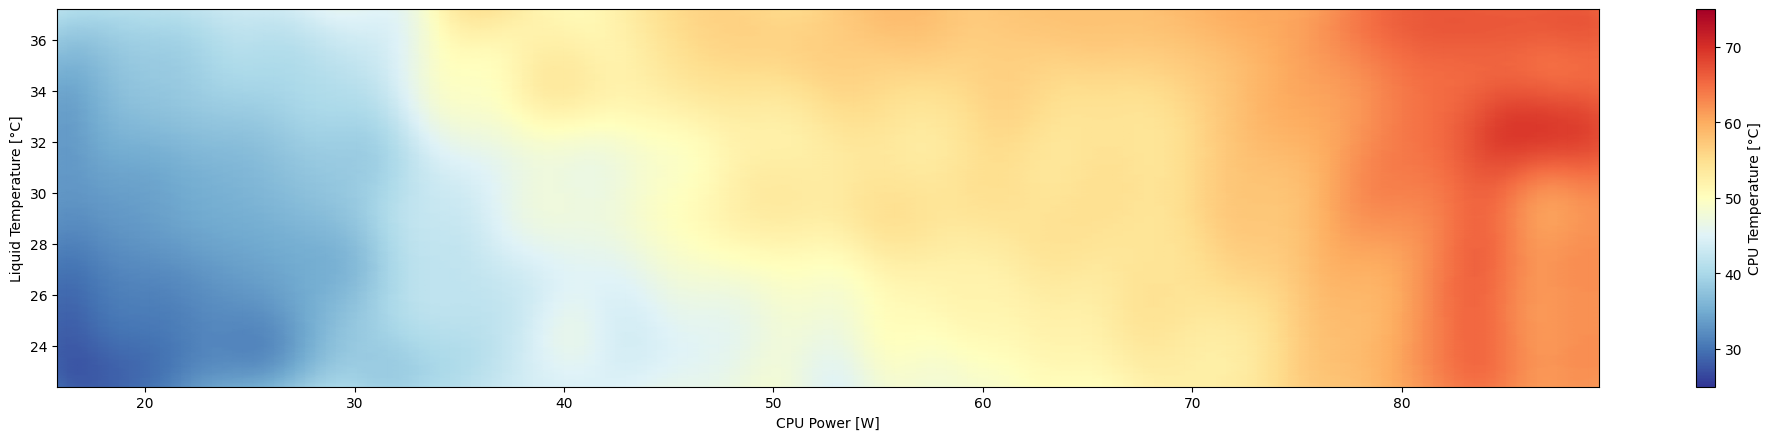

In [17]:
# Plot the predicted temperature as a function of the Liquid Temperature and the CPU Power Draw in a 2d image
height = 5
width = height / (X.max() - X.min()) * (Y.max() - Y.min())
fig, ax = plt.subplots(figsize=(width, height), dpi=100)
img = ax.pcolormesh(Y, X, Z, cmap=plt.cm.get_cmap('RdYlBu').reversed(), vmin=25, vmax=75, shading='gouraud')

# Label the axes
ax.set_ylabel('Liquid Temperature [°C]')
ax.set_xlabel('CPU Power [W]')

# Show a colorbar with the same height as the image
cbar = ax.figure.colorbar(img, shrink=1)
cbar.ax.set_ylabel('CPU Temperature [°C]');